```
This software is part of GPU Ocean. 

Copyright (C) 2023 SINTEF Digital

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# Reproducing CDKLM - Example 5

Reproducing results from the paper by Chertock et al. (2017), where the CDKLM originally was proposed.

There's a typo in their equation for h(r,0). This is fixed in the numerical example in Liu, Chertock, Kurganov (2019).

This should be a steady state, but it is hard to believe from the initial conditions.
Also, the values are very small, so that $\eta$ is 5 orders of magnitude smaller than $H$.



In [9]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
from scipy import integrate

#For plotting
from matplotlib import pyplot as plt
import matplotlib as mpl
plt.rcParams["animation.html"] = "jshtml"
mpl.rcParams['figure.facecolor'] = 'white'
plt.rcParams["image.origin"] = "lower"


from gpuocean.SWEsimulators import CDKLM16, KP07
from gpuocean.utils import Common, IPythonMagic


In [10]:
%cuda_context_handler gpu_ctx

### Initial conditions
See reference paper

### Boundary conditions
They don't state their BC. We use periodic.

In [24]:
nx = 200
ny = 200
x_start = -1
x_end = 1
y_start = -1
y_end = 1

eps = 0.05

sim_args = {
    "gpu_ctx" : gpu_ctx,
    "nx" : nx, "ny" : ny,
    "dx" : (x_end - x_start)/nx, 
    "dy" : (y_end - y_start)/ny,
    "f" : 1.0/eps,
    "g" : (1.0/eps)**2,
    "r" : 0,
    #"rk_order": 3
    "boundary_conditions": Common.BoundaryConditions(2,2,2,2)
}

cdklm_args = {
    "courant_number" : 0.5,
    "dt" : 0
}

x = np.arange(x_start+0.5*sim_args["dx"], x_end, sim_args["dx"])
y = np.arange(y_start+0.5*sim_args["dx"], y_end, sim_args["dy"])

print(x[0], x[-1])


sim_args["f"], sim_args["g"]

-0.995 0.9950000000000018


(20.0, 400.0)

In [25]:
def h(r, eps):
    tmp = 0.0
    if r < 0.2:
        tmp = (2.5*(1+ (5*eps*eps)))*r*r
    elif r < 0.4:
        a = 0.1*(1 + 5*eps*eps)
        b = 2*r - 0.3 - 2.5*r*r
        c = 4*np.log(5*r) + 3.5 - 20*r + 12.5*r*r
        tmp = a + b + eps*eps*c
    else:
        tmp = 0.2*(1.0 - (10*eps*eps)  + (20*eps*eps*np.log(2)))
    return eps*eps*tmp

def gamma(r):
    if r < 0.2:
        return 5
    elif r < 0.4:
        return (2/r) - 5
    else:
        return 0


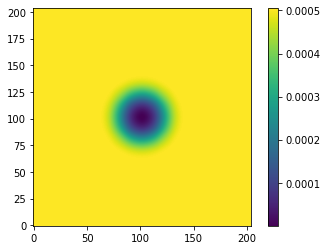

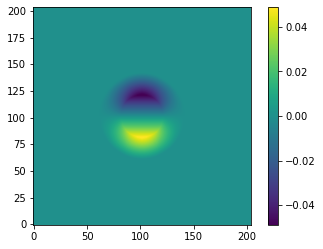

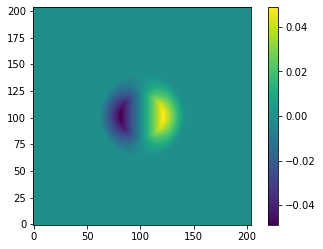

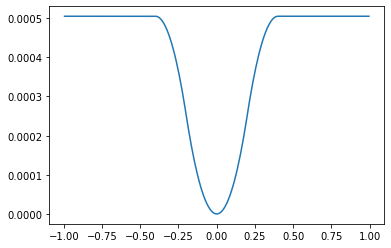

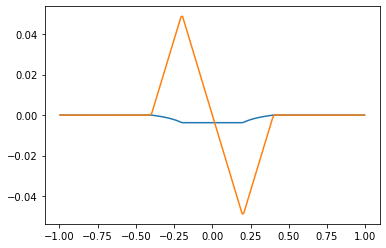

In [27]:
dataShape = (sim_args["ny"] + 4, 
             sim_args["nx"] + 4)

H_const = 1.0
H = np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32) * H_const
eta0 = np.ones(dataShape, dtype=np.float64)*h(1, eps)
u0 = np.zeros(dataShape, dtype=np.float64)
v0 = np.zeros(dataShape, dtype=np.float64)

for j in range(ny):
    for i in range(nx):
        r = np.sqrt(x[i]*x[i] + y[j]*y[j])
        eta0[2+j, 2+i] = h(r, eps) 
        u0[2+j, 2+i] = -eps*y[j]*gamma(r)
        v0[2+j, 2+i] =  eps*x[i]*gamma(r)


hu0 = u0*(eta0 + H_const)
hv0 = v0*(eta0 + H_const)

data_args = {
    "H" : H, 
    "eta0" : eta0.astype(np.float32), 
    "hu0": hu0.astype(np.float32), 
    "hv0": hv0.astype(np.float32)
}

plt.figure()
plt.imshow(eta0)
plt.colorbar()

plt.figure()
plt.imshow(u0)
plt.colorbar()

plt.figure()
plt.imshow(v0)
plt.colorbar()


plt.figure()
plt.plot(x, eta0[2:-2, 102])
plt.figure()
plt.plot(x, v0[2:-2, 100])
plt.plot(x, u0[2:-2, 100])

In [14]:
if "sim" in globals():
    sim.cleanUp()

sim = CDKLM16.CDKLM16(**data_args, **sim_args, **cdklm_args, theta=1.7)
error_cu = np.zeros(21)
for i in range(1, 21):
    sim.step(0.5)
    eta, hu, hv = sim.download(interior_domain_only=False)
    eta_diff = eta0 - eta
    error_cu[i] = np.linalg.norm(eta_diff)
u = hu/(eta + H_const)
v = hv/(eta + H_const)




C:\Users\havardh\playground-win\gpuocean\havahol-gpuocean\src\gpuocean\SWEsimulators\CDKLM16.py:219: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu

  jit_compile_args={


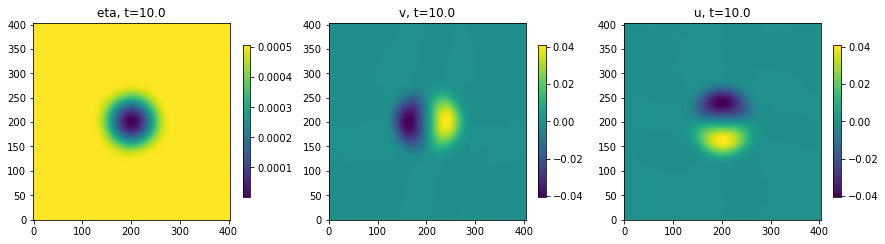

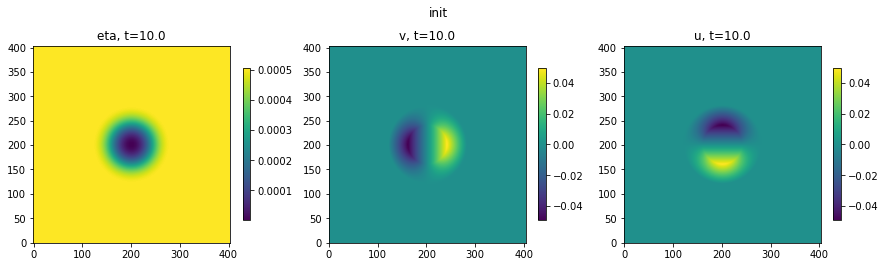

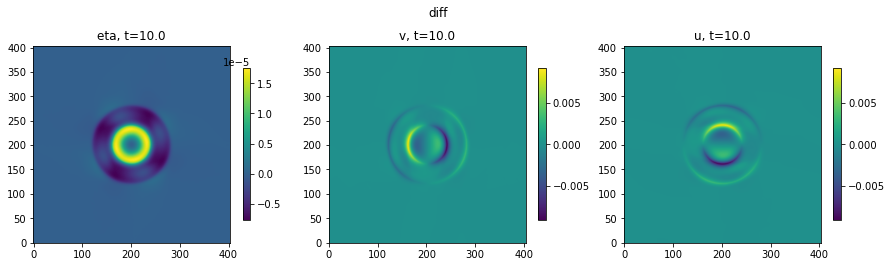

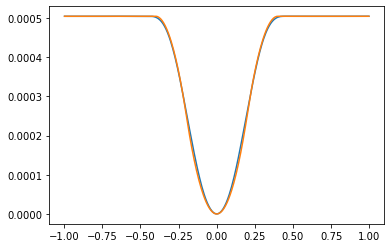

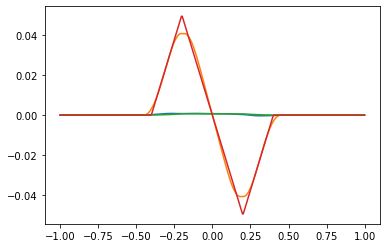

In [23]:
def plot3(eta, u, v, title=None):
    fig = plt.figure(figsize=(15,4))
    ax_eta = plt.subplot(1,3,1)
    im_eta = ax_eta.imshow(eta)
    ax_eta.set_title("eta, t="+str(sim.t))
    plt.colorbar(im_eta, shrink=0.7)
    
    ax_v = plt.subplot(1,3,2)
    im_v = ax_v.imshow(v)
    ax_v.set_title("v, t="+str(sim.t))
    plt.colorbar(im_v, shrink=0.7)


    ax_hv = plt.subplot(1,3,3)
    im_u = ax_hv.imshow(u)
    ax_hv.set_title("u, t="+str(sim.t))
    plt.colorbar(im_u, shrink=0.7)

    plt.suptitle(title)

plot3(eta, u, v)
plot3(eta0, u0, v0, "init")
plot3(eta-eta0, u-u0, v-v0, "diff")

plt.figure()
plt.plot(x, eta[2:-2, nx//2+2])
plt.plot(x, eta0[2:-2, nx//2+2])
plt.figure()
plt.plot(x, v[2:-2, nx//2+2])
plt.plot(x, u[2:-2, nx//2+2])
plt.plot(x, v0[2:-2, nx//2+2])
plt.plot(x, u0[2:-2, nx//2+2])



C:\Users\havardh\playground-win\gpuocean\havahol-gpuocean\src\gpuocean\SWEsimulators\CDKLM16.py:219: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu

  jit_compile_args={


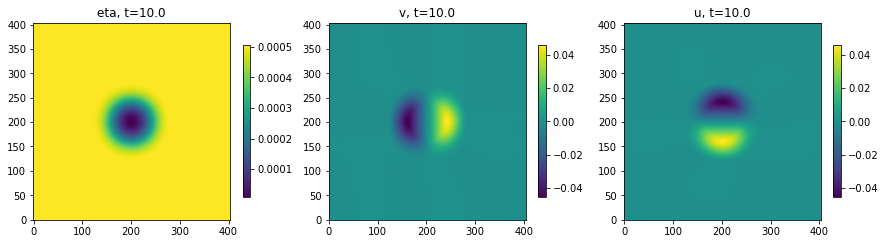

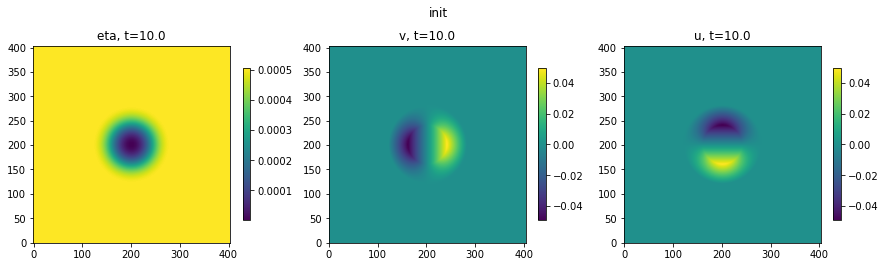

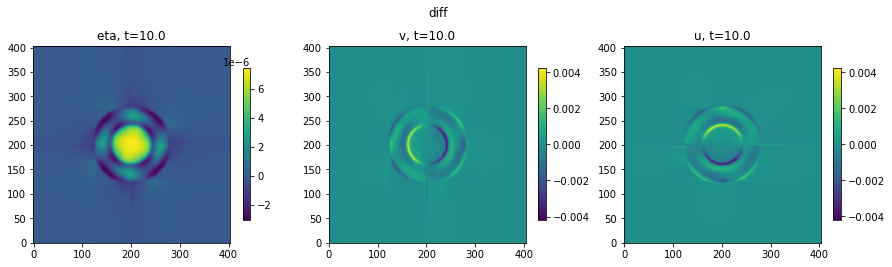

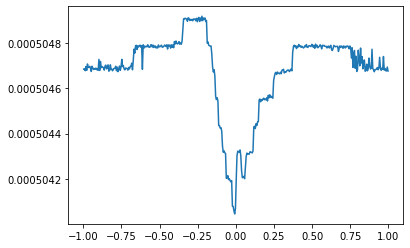

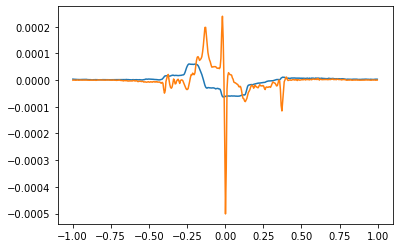

In [16]:
if "su_sim" in globals():
    su_sim.cleanUp()

su_sim = CDKLM16.CDKLM16(**data_args, **sim_args, **cdklm_args, central_upwind=False, theta=1.5)
error_su = np.zeros(21)
error_t = np.zeros(21)
for i in range(1, 21):
    su_sim.step(0.5)
    su_eta, su_hu, su_hv = su_sim.download(interior_domain_only=False)
    eta_diff = eta0 - su_eta
    error_su[i] = np.linalg.norm(eta_diff)
    error_t[i] = su_sim.t
su_u = su_hu/(su_eta + H_const)
su_v = su_hv/(su_eta + H_const)




plot3(su_eta, su_u, su_v)
plot3(eta0, u0, v0, "init")
plot3(su_eta-eta0, su_u-u0, su_v-v0, "diff")

plt.figure()
plt.plot(x, su_eta[2:-2, 100])
plt.figure()
plt.plot(x, su_v[2:-2, 100])
plt.plot(x, su_u[2:-2, 100])


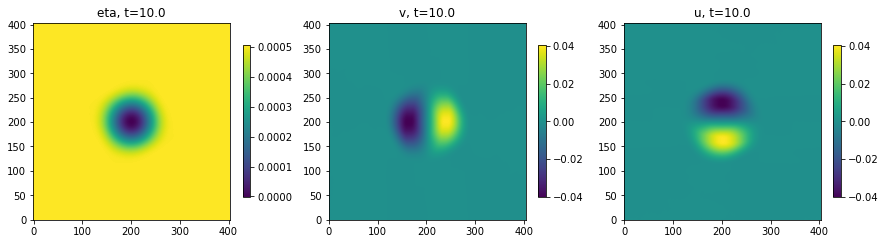

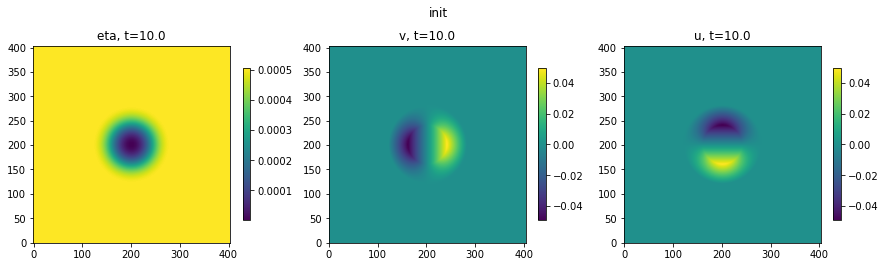

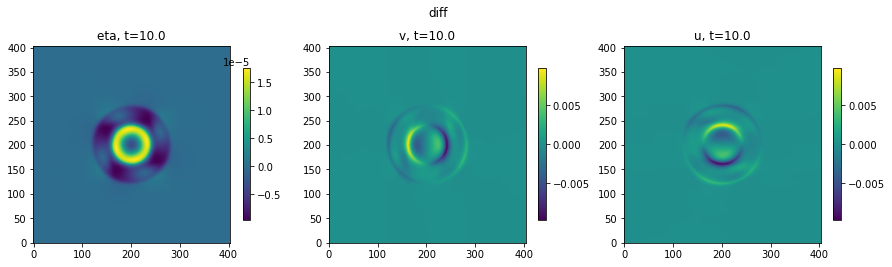

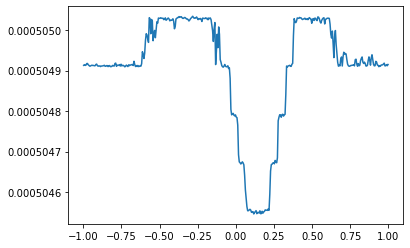

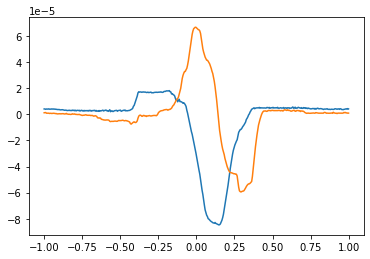

In [17]:
if "kp_sim" in globals():
    kp_sim.cleanUp()


kp_sim = KP07.KP07(**data_args, **sim_args, dt=su_sim.dt, theta=1.5)
error_kp = np.zeros(21)
error_t = np.zeros(21)
for i in range(1, 21):
    kp_sim.step(0.5)
    kp_eta, kp_hu, kp_hv = kp_sim.download(interior_domain_only=False)
    eta_diff = eta0 - kp_eta
    error_kp[i] = np.linalg.norm(eta_diff)
    error_t[i] = kp_sim.t
kp_u = kp_hu/(kp_eta + H_const)
kp_v = kp_hv/(kp_eta + H_const)




plot3(kp_eta, kp_u, kp_v)
plot3(eta0, u0, v0, "init")
plot3(kp_eta-eta0, kp_u-u0, kp_v-v0, "diff")

plt.figure()
plt.plot(x, kp_eta[2:-2, 100])
plt.figure()
plt.plot(x, kp_v[2:-2, 100])
plt.plot(x, kp_u[2:-2, 100])


3.116902007604949e-05


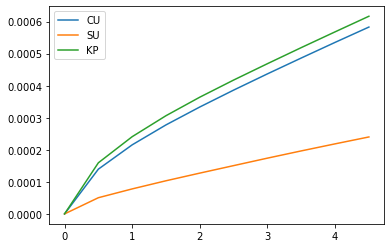

In [18]:
print(sim.dt)
plt.figure()
plt.plot(error_t[0:10], error_cu[0:10], label='CU')
plt.plot(error_t[0:10], error_su[0:10], label='SU')
plt.plot(error_t[0:10], error_kp[0:10], label="KP")
plt.legend()

In [19]:
1*2*2*2

8